# Session 7 : Pattern detection and extraction

>Intelligence Artificielle & Machine Learning pour la modélisation de séries temporelles et de signaux<br />
>Master 1 Parcours IA ENS Paris Saclay<br />
>Laurent Oudre (laurent.oudre@ens-paris-saclay.fr)

This seventh and last session is dedicated to pattern discovery and detection in time series. Slides are available at http://www.laurentoudre.fr/signalml.html

1. **Library and data loading**
2. **Exploratory study**
3. **Pattern detection**
4. **Distance-based pattern extraction**

## 1. Library and data loading

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance
from scipy.signal import find_peaks
import time

In [2]:
plt.rcParams['figure.figsize'] = (10,5)

In [3]:
# Data loading
npzfile = np.load('Session7.npz')
x1=npzfile['x1']
x2=npzfile['x2']
x3=npzfile['x3']
p=npzfile['p']
Fs=100

# First investigations
N=np.size(x1)
Np=np.size(p)
print("Number of samples in the signals : {N}".format(**locals()))
print("Number of signals in the pattern : {Np}".format(**locals()))

Number of samples in the signals : 2000
Number of signals in the pattern : 200


## 2. Exploratory study

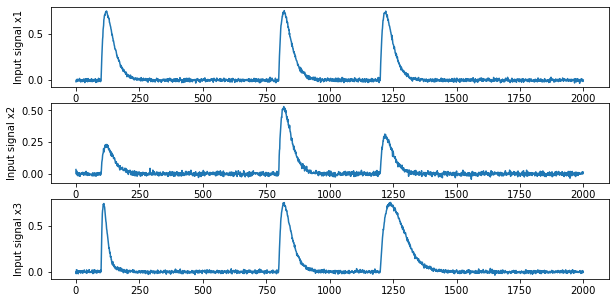

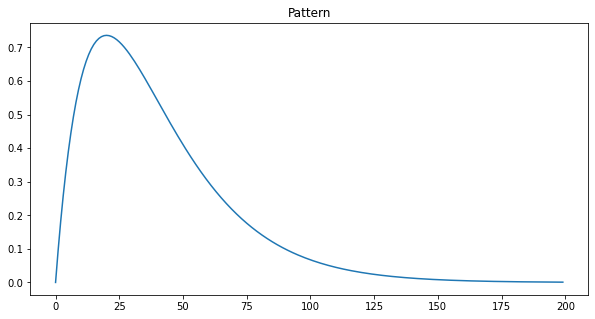

In [4]:
# Plot of the 3 input signals and the pattern
plt.figure()
plt.subplot(3,1,1)
plt.plot(x1)
plt.ylabel('Input signal x1')
plt.subplot(3,1,2)
plt.plot(x2)
plt.ylabel('Input signal x2')
plt.subplot(3,1,3)
plt.plot(x3)
plt.ylabel('Input signal x3')

plt.figure()
plt.plot(p)
plt.title('Pattern')

plt.show()

## 3. Pattern detection

In order to retrieve the pattern  $\mathbf{p} \in \mathcal{P}$ of length $N_p$ in a time series $\mathbf{x} = x_{1:N}$ of length $N$, we need to compute all distances
 $$d_i = d(\mathbf{p},x_{i:i+N_p-1})$$
 for $1 \leq i \leq N - N_d +1$ and where
 $x_{i:i+N_d-1}$ is a the subsequence of $\mathbf{x}$ starting at $i$ and of length $N_p$
 
 We will test three different distances :
 * Euclidean distance (fast implementation with Mueen algorithm)
 * Normalized Euclidean distance (fast implementation with Mueen algorithm)
 * DTW (naive implementation)

### 3.1 Euclidean distance

In [5]:
# Naive implementation of sliding Euclidean distance
def distance_profile_EUC(x,p):
    N=np.size(x)
    Np=np.size(p)
    d=np.zeros((N-Np,))
    for i in range(N-Np):
        d[i]=np.linalg.norm(x[i:i+Np]-p)
    return d

In [6]:
# Optimized implementation of sliding Euclidean distance with Mueen's algorithm
def fast_distance_profile_EUC(x,p):
    c2=np.cumsum(np.concatenate(([0],x))**2)
    N=np.size(x)
    Np=np.size(p)
    cp=np.sum(p**2)
    p_=np.zeros((N,))
    p_[0:Np]=np.flip(p)
    r=np.real(np.fft.ifft(np.multiply(np.fft.fft(x),np.fft.fft(p_))))
    d=np.sqrt(np.maximum(c2[Np:-1]-c2[:N-Np]+cp-2*r[Np-1:N-1],0))
    return d

In [7]:
# Comparison of the performances of the two methods
start = time.time()
d=distance_profile_EUC(x1,p)
elapsed_time_fl = (time.time() - start)
print("Computation time for regular EUC distance profile : ", elapsed_time_fl ,"sec" )
start = time.time()
d2=fast_distance_profile_EUC(x1,p)
elapsed_time_fl = (time.time() - start)
print("Computation time for optimized EUC distance profile : ", elapsed_time_fl ,"sec" )
np.mean(np.abs(d-d2))

Computation time for regular EUC distance profile :  0.012964725494384766 sec
Computation time for optimized EUC distance profile :  0.000997781753540039 sec


2.9288762773107793e-15

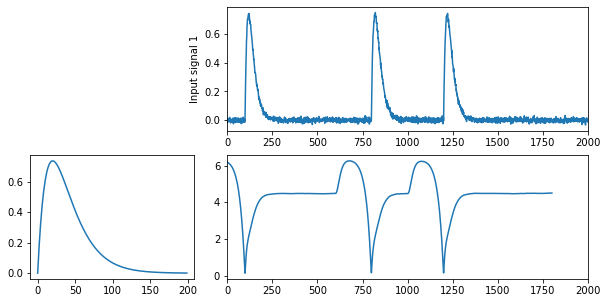

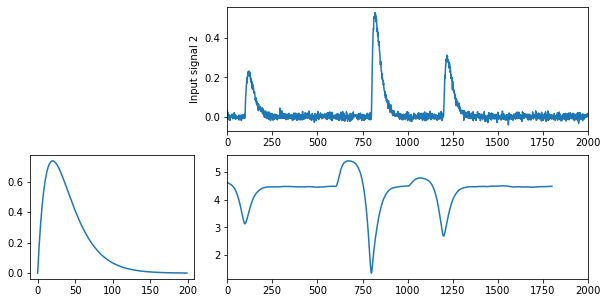

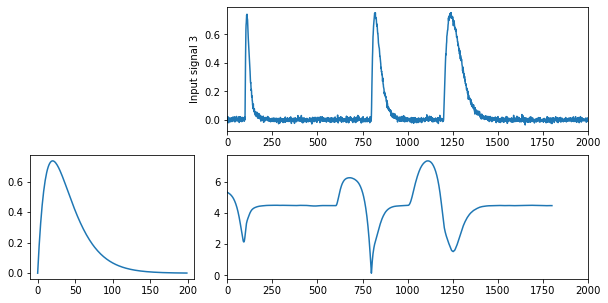

In [8]:
# Example of pattern detection with standard Euclidean distance
d1=fast_distance_profile_EUC(x1,p)
plt.figure()
plt.subplot(2,3,(2,3))
plt.plot(x1)
plt.ylabel('Input signal 1')
plt.xlim([0,N])
plt.subplot(2,3,4)
plt.plot(p)
plt.subplot(2,3,(5,6))
plt.plot(d1)
plt.xlim([0,N])

d2=fast_distance_profile_EUC(x2,p)
plt.figure()
plt.subplot(2,3,(2,3))
plt.plot(x2)
plt.ylabel('Input signal 2')
plt.xlim([0,N])
plt.subplot(2,3,4)
plt.plot(p)
plt.subplot(2,3,(5,6))
plt.plot(d2)
plt.xlim([0,N])

d3=fast_distance_profile_EUC(x3,p)
plt.figure()
plt.subplot(2,3,(2,3))
plt.plot(x3)
plt.ylabel('Input signal 3')
plt.xlim([0,N])
plt.subplot(2,3,4)
plt.plot(p)
plt.subplot(2,3,(5,6))
plt.plot(d3)
plt.xlim([0,N])
plt.show()

The indexes where the pattern has been detected corresponds to the peaks with small distance values. Note that for input signal 2 and 3, the detection is not as good as for input signal 1, since the patterns are either of different amplitudes (input signal 2) or different durations (input signal 3) 

### 3.2 Normalized Euclidean distance

In [9]:
# Naive implementation of sliding normalized Euclidean distance
def distance_profile_nEUC(x,p):
    N=np.size(x)
    Np=np.size(p)
    d=np.zeros((N-Np,))
    p_=(p-np.mean(p))/np.std(p)
    for i in range(N-Np):
        x_=(x[i:i+Np]-np.mean(x[i:i+Np]))/np.std(x[i:i+Np])
        d[i]=np.linalg.norm(x_-p_)
    return d

In [10]:
# Optimized implementation of sliding Euclidean distance with Mueen's algorithm
def fast_distance_profile_nEUC(x,p):
    c=np.cumsum(np.concatenate(([0],x)))
    c2=np.cumsum(np.concatenate(([0],x))**2)
    N=np.size(x)
    Np=np.size(p)
    p_=(p-np.mean(p))/np.std(p)
    p__=np.zeros((N,))
    p__[0:Np]=np.flip(p_)
    r=np.real(np.fft.ifft(np.multiply(np.fft.fft(x),np.fft.fft(p__))))
    vari=np.sqrt(Np * (c2[Np:-1]-c2[:N-Np]) -  (c[Np:-1]-c[:N-Np])**2)
    d=np.sqrt(np.maximum(2*Np*(1-np.divide(r[Np-1:N-1],vari)),0))
    return d

In [11]:
# Comparison of the performances of the two methods
start = time.time()
d=distance_profile_nEUC(x1,p)
elapsed_time_fl = (time.time() - start)
print("Computation time for regular EUC distance profile : ", elapsed_time_fl ,"sec" )
start = time.time()
d2=fast_distance_profile_nEUC(x1,p)
elapsed_time_fl = (time.time() - start)
print("Computation time for optimized EUC distance profile : ", elapsed_time_fl ,"sec" )
np.mean(np.abs(d-d2))

Computation time for regular EUC distance profile :  0.07283711433410645 sec
Computation time for optimized EUC distance profile :  0.0009930133819580078 sec


2.5331668861304657e-13

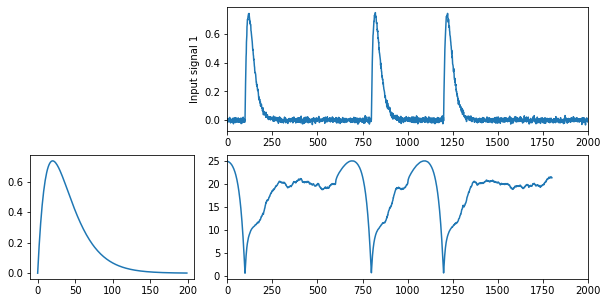

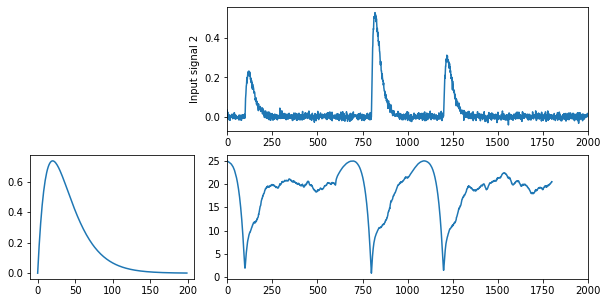

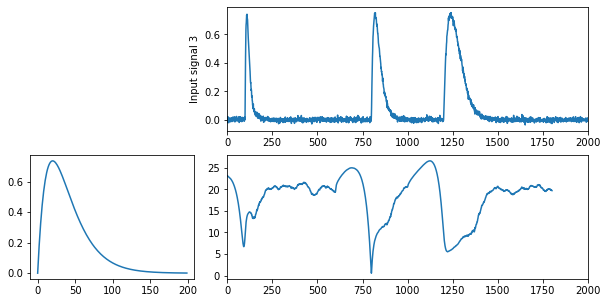

In [12]:
# Example of pattern detection with normalized Euclidean distance
d1=fast_distance_profile_nEUC(x1,p)
plt.figure()
plt.subplot(2,3,(2,3))
plt.plot(x1)
plt.ylabel('Input signal 1')
plt.xlim([0,N])
plt.subplot(2,3,4)
plt.plot(p)
plt.subplot(2,3,(5,6))
plt.plot(d1)
plt.xlim([0,N])

d2=fast_distance_profile_nEUC(x2,p)
plt.figure()
plt.subplot(2,3,(2,3))
plt.plot(x2)
plt.ylabel('Input signal 2')
plt.xlim([0,N])
plt.subplot(2,3,4)
plt.plot(p)
plt.subplot(2,3,(5,6))
plt.plot(d2)
plt.xlim([0,N])

d3=fast_distance_profile_nEUC(x3,p)
plt.figure()
plt.subplot(2,3,(2,3))
plt.plot(x3)
plt.ylabel('Input signal 3')
plt.xlim([0,N])
plt.subplot(2,3,4)
plt.plot(p)
plt.subplot(2,3,(5,6))
plt.plot(d3)
plt.xlim([0,N])
plt.show()

Contrary to standard Euclidean distance, the results are now very good with both input signals 1 and 2, because of the robustess with respect to amplitude changes. 

### 3.3 Dynamic Time Warping

In [13]:
def dtw(x,y,w=np.Inf):    
    Nx=np.size(x)
    Ny=np.size(y)
    x_=np.reshape(x,(Nx,1))
    y_=np.reshape(y,(Ny,1))
    # Computation of the distance matrix
    D=distance.cdist(x_, y_, 'euclidean')**2
    # Computation of the cumulative distance matrix
    C=np.Inf*np.ones((Nx+1,Ny+1))
    C[0,0]=0    
    for i in range(1,Nx+1):
        for j in range(np.int(np.maximum(1,i-w)),np.int(np.minimum(Ny+1,i+w+1))):
            C[i,j] = D[i-1,j-1] + np.amin([C[i-1,j-1],C[i-1,j],C[i,j-1]])
    # Computation of the path
    path=[[Nx-1,Ny-1]]
    i=Nx-1
    j=Ny-1
    while i>0 and j>0:
        ind=np.argmin([C[i-1,j-1],C[i-1,j],C[i,j-1]])
        if ind==0:
            path = np.insert(path, 0, [i-1, j-1], axis=0)
            i-=1
            j-=1
        elif ind==1:
            path = np.insert(path, 0, [i-1, j], axis=0)
            i-=1
        elif ind==2:
            path=np.insert(path, 0, [i, j-1], axis=0)
            j-=1
        
    return np.sqrt(C[Nx,Ny]),path

In [14]:
# Plots the two signals and the path
def figure_dtw(x,y,path):
    plt.figure()
    N=np.size(x)
    M=np.size(y)
    Npath,K=np.shape(path)
    x_max=np.max(x)
    y_min=np.min(y)
    y=y+(x_max-y_min+1)
    for i in range(Npath):
        plt.plot([path[i,0],path[i,1]],[x[path[i,0]],y[path[i,1]]],'-g',linewidth=0.5)
    plt.plot(x)
    plt.plot(y)
    plt.show()

DTW distance :  0.16920713854002906


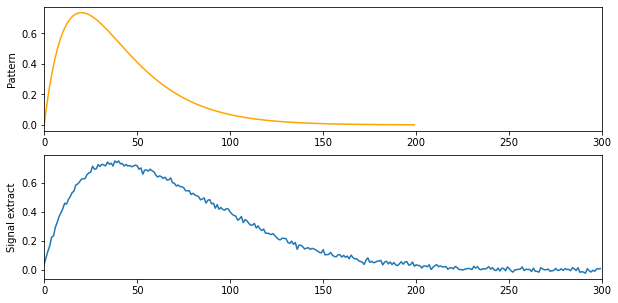

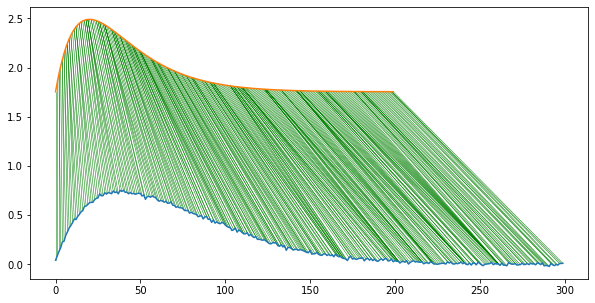

In [15]:
# Computation of the DTW between the pattern and a portion of the signal
x_sub=x3[1200:1500]
d,path=dtw(x_sub,p)

# Plot of the 2 signals
plt.figure()
plt.subplot(2,1,1)
plt.plot(p,color='orange')
plt.ylabel('Pattern')
plt.xlim([0,np.maximum(np.size(x_sub),np.size(p))])
plt.subplot(2,1,2)
plt.plot(x_sub)
plt.ylabel('Signal extract')
plt.xlim([0,np.maximum(np.size(x_sub),np.size(p))])

print("DTW distance : ",d)

# Plot of the path
figure_dtw(x_sub,p,path)

## 4. Distance-based pattern extraction

In order to automatically extract patterns of length $L$ from a time series, a simple solution is to compute all distances between subsequences of length $L$ within the time series. Indeed, if a subsequence corresponds to a pattern, it is likely to be present at several instants in the signals, and thus to have a small distances with several other subsequences. This algorithm allows the computation of the matrix profile defined by

$$m_i = \min_{j>i+L \mbox{ or } j<i-L} d(x_{i:i+L-1},x_{j:j+L-1})$$

Small values of $\mathbf{m}$ corresponds to  possible starts indexes of patterns.


In [16]:
# Computes the matrix profile according to the normalized Euclidean distance
def matrix_profile(x,w):
    N=np.size(x)
    d=np.Inf*np.ones((N-w,))
    for i in range(N-w):
        x_=x[i:i+w]
        c=fast_distance_profile_nEUC(x,x_)
        c[np.maximum(0,np.int(i-w)):np.minimum(N-w,np.int(i+w))]=np.Inf
        d=np.minimum(d,c)
    return d

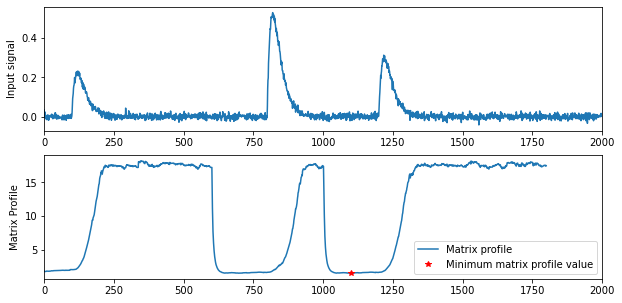

In [17]:
# Computation and plot of the matrix profile
L=200
m=matrix_profile(x2,L)

plt.figure()
plt.subplot(2,1,1)
plt.plot(x2)
plt.xlim([0,np.size(x2)])
plt.ylabel('Input signal')
plt.subplot(2,1,2)
plt.plot(m)
plt.xlim([0,np.size(x2)])
plt.ylabel('Matrix Profile')
ind=np.argmin(m)
plt.plot(ind,m[ind],'*r')
plt.legend(("Matrix profile","Minimum matrix profile value"))
plt.show()

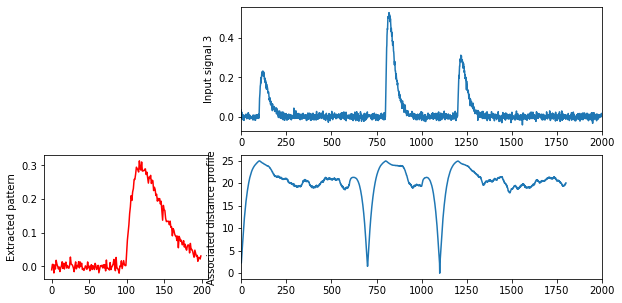

In [18]:
# Pattern extraction from matrix profile
p=x2[ind:ind+L]
d=fast_distance_profile_nEUC(x2,p)

plt.figure()
plt.subplot(2,3,(2,3))
plt.plot(x2)
plt.ylabel('Input signal 3')
plt.xlim([0,N])
plt.subplot(2,3,4)
plt.plot(p,'-r')
plt.ylabel('Extracted pattern')
plt.subplot(2,3,(5,6))
plt.plot(d)
plt.ylabel('Associated distance profile')
plt.xlim([0,N])
plt.show()


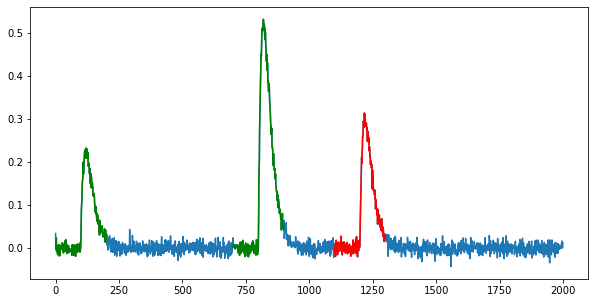

In [19]:
# Analysis of the distance profile to retrieve the associated pattern
threshold=3
a=find_peaks(-d)
a=a[0]
a=a[d[a]<3]

t=np.arange(N)
plt.figure()
plt.plot(t,x2)
plt.plot(t[a[0]:a[0]+L],x2[a[0]:a[0]+L],'-g')
plt.plot(t[a[1]:a[1]+L],x2[a[1]:a[1]+L],'-g')
plt.plot(t[a[2]:a[2]+L],x2[a[2]:a[2]+L],'-r')
plt.show()